In [1]:
import os
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

seed = 2024

In [2]:
%pip install pandas numpy igraph matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
node_df = pd.read_csv("processed_data/node_attributes_file.csv")
edges_df = pd.read_csv("processed_data/edge_file.csv")
stations_geo_df = pd.read_csv("processed_data/stations_geo.csv")

# Task 1: Network Resilience

### Construct a network

*   Node: stations
*   Edge: trips between these stations (undirectional)
*   Edge weights: volume of trips

In [4]:
# Construct undirectional network datafile
edges_df_total = edges_df[['start_station_id', 'end_station_id', 'trip_count']].copy()
edges_df_total[['start_station_id', 'end_station_id']] = edges_df_total[['start_station_id', 'end_station_id']].astype(int)

# Sort the station IDs within each row to handle them as undirected edges
edges_df_total['min_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].min(axis=1)
edges_df_total['max_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].max(axis=1)

# Group by the sorted station IDs and sum the trip counts
undirectional_edges_df = edges_df_total.groupby(['min_station_id', 'max_station_id'])['trip_count'].sum().reset_index()

# Remove nodes where min = max
undirectional_edges_df = undirectional_edges_df[undirectional_edges_df.min_station_id != undirectional_edges_df.max_station_id]

In [5]:
# undirectional_edges_df.to_csv("processed_data/total_edge_undirectional.csv", index = False)

In [6]:
# Construct undirectional network
min_nodes = undirectional_edges_df['min_station_id'].tolist()
max_nodes = undirectional_edges_df['max_station_id'].tolist()
weights = undirectional_edges_df['trip_count'].tolist()

g = ig.Graph.TupleList(edges=zip(min_nodes, max_nodes), directed=False, edge_attrs={'weight': weights})

print(f"Network Nodes: {len(g.vs)}, Edges: {len(g.es)}")

Network Nodes: 773, Edges: 81754


In [7]:
%pip install networkx scipy

Note: you may need to restart the kernel to use updated packages.


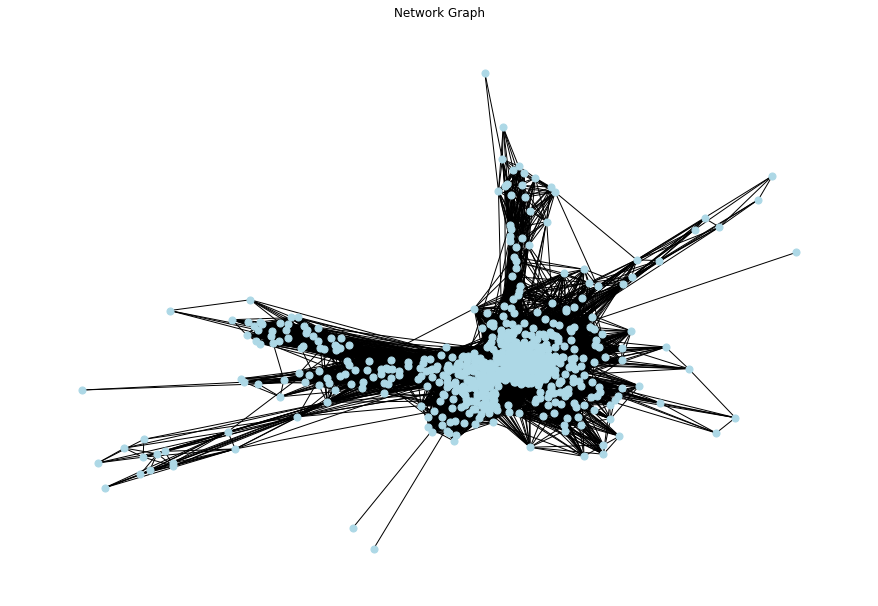

In [8]:
import networkx as nx
import scipy
import scipy.sparse

network_nx = nx.Graph(g.get_edgelist())
plt.figure(figsize=(12, 8))

nx.draw(network_nx, node_size=50, node_color='lightblue', with_labels=False)
plt.title('Network Graph')
plt.show()

In [9]:
def draw_geographical_network(undirectional_edges_df):
    # Map the nodes based on geo location
    nodes = stations_geo_df.set_index('station_id').to_dict('index')
    G = nx.Graph()
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)

    # Add edges with weights to the graph
    edges = undirectional_edges_df[['min_station_id', 'max_station_id', 'trip_count']]
    G.add_weighted_edges_from(edges.values)

    # Calculate node degrees for sizing (no need to set node attributes)
    degrees = dict(G.degree())
    max_degree = max(degrees.values(), default=1)
    node_sizes = [degrees.get(node, 0) * 200 / max_degree for node in G.nodes()]

    degree_threshold = max_degree * 0.9

    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, 'weight').values()
    max_weight = max(weights, default=1)
    weights_normalized = [weight * 10 / max_weight for weight in weights]

    # Get positions from node attributes
    pos = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True)}

    # Draw the network with improved visual parameters
    plt.figure(figsize=(15, 12))
    ax = plt.gca()
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='deepskyblue', edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.7)
    plt.title('Network Graph Based on Geographical Locations')
    plt.axis('off')
    plt.show()

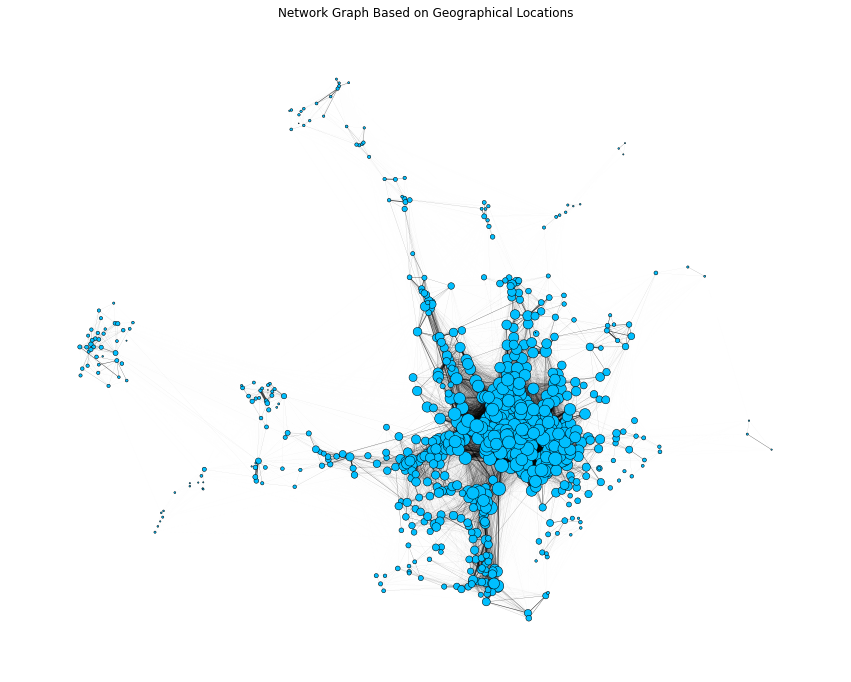

In [10]:
draw_geographical_network(undirectional_edges_df)

### 1.1:
Implement the two types of node deletion strategies on your network, and plot the associated changes in average shortest path length (i.e., average distance) & diameter as a function of the fraction of nodes removed. Do the resulting plots resemble the Fig. 2 on Pg. 12 of the Albert et al. (2000) paper above? Why do you (/don’t you) see this pattern?

C:\Users\fangz\AppData\Local\Temp\ipykernel_3648\2497330095.py:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_to_remove = random.sample(network.nodes(), num_nodes_to_remove)


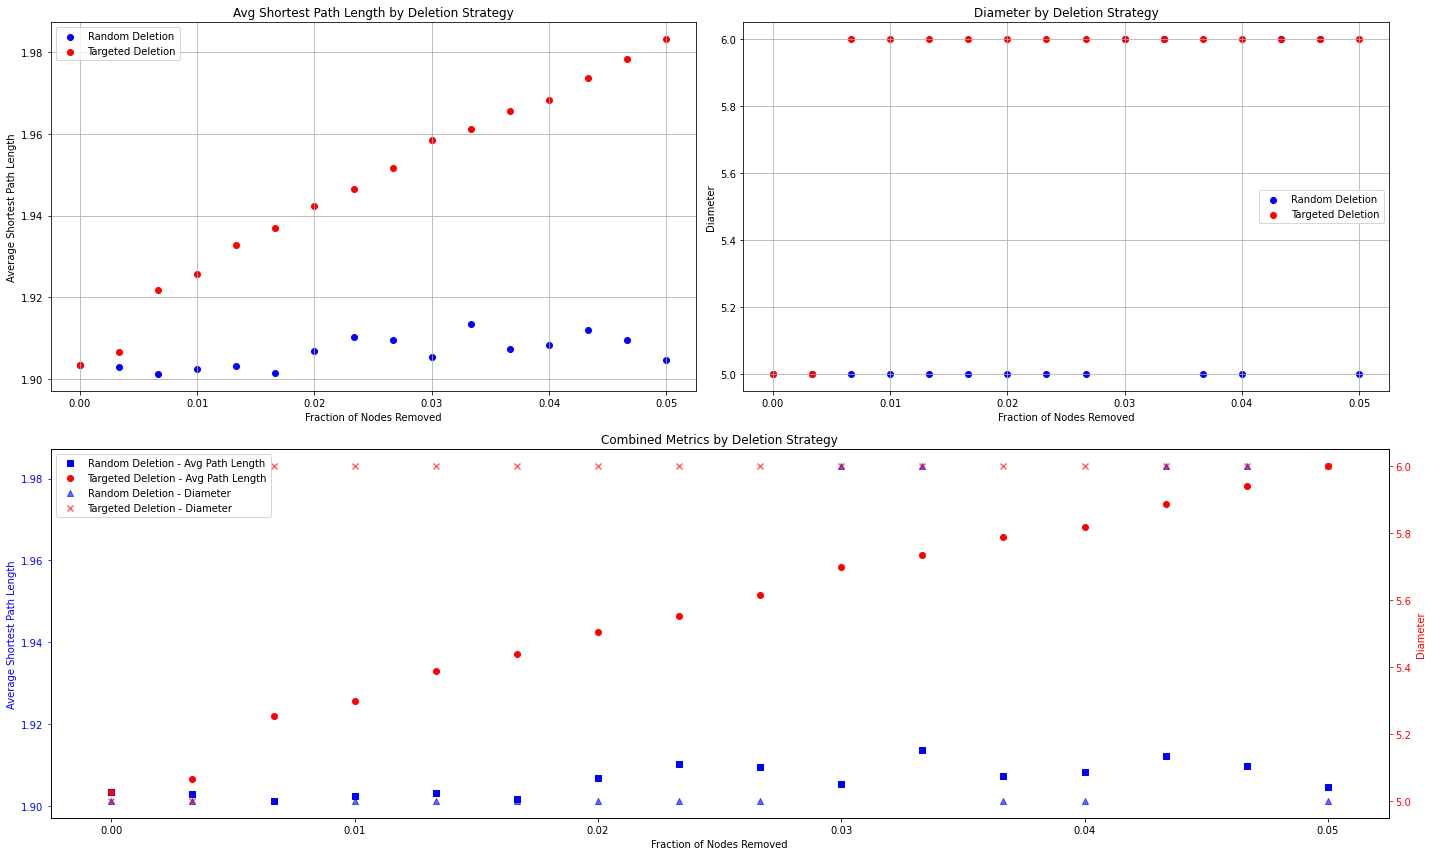

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

# Initialize lists to store results for plotting
fractions = np.linspace(0, 0.05, 16)  
random_avg_path_lengths = []
random_diameters = []
targeted_avg_path_lengths = []
targeted_diameters = []

# Define the function to find the longest shortest path in the largest connected component
def longest_shortest_path_in_largest_component(network):
    if nx.is_connected(network):
        return nx.diameter(network)
    else:
        largest_cc = max(nx.connected_components(network), key=len)
        subgraph = network.subgraph(largest_cc)
        return nx.diameter(subgraph)

# Define the random_node_deletion function
def random_node_deletion(network, fraction):
    num_nodes_to_remove = int(network.number_of_nodes() * fraction)
    nodes_to_remove = random.sample(network.nodes(), num_nodes_to_remove)
    network_copy = network.copy()
    network_copy.remove_nodes_from(nodes_to_remove)
    return network_copy

# Define the targeted_node_deletion function
def targeted_node_deletion(network, fraction):
    num_nodes_to_remove = int(network.number_of_nodes() * fraction)
    degrees = dict(network.degree())
    sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)[:num_nodes_to_remove]
    network_copy = network.copy()
    network_copy.remove_nodes_from(sorted_nodes)
    return network_copy

# Iterate over each fraction and perform deletions
for fraction in fractions:
    # Random node deletion
    random_network = random_node_deletion(network_nx, fraction)
    if nx.is_connected(random_network):
        random_avg_path_lengths.append(nx.average_shortest_path_length(random_network))
        random_diameters.append(nx.diameter(random_network))
    else:
        largest_component = random_network.subgraph(max(nx.connected_components(random_network), key=len))
        random_avg_path_lengths.append(nx.average_shortest_path_length(largest_component))
        random_diameters.append(longest_shortest_path_in_largest_component(random_network))

    # Targeted node deletion
    targeted_network = targeted_node_deletion(network_nx, fraction)
    if nx.is_connected(targeted_network):
        targeted_avg_path_lengths.append(nx.average_shortest_path_length(targeted_network))
        targeted_diameters.append(nx.diameter(targeted_network))
    else:
        largest_component = targeted_network.subgraph(max(nx.connected_components(targeted_network), key=len))
        targeted_avg_path_lengths.append(nx.average_shortest_path_length(largest_component))
        targeted_diameters.append(longest_shortest_path_in_largest_component(targeted_network))

# Creating a figure and subplots
fig = plt.figure(figsize=(20, 12))  # Adjust figure size as needed

# First two plots in the first row
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

# Third plot that spans the entire second row
ax3 = fig.add_subplot(2, 1, 2)

# Plot for average shortest path length
ax1.scatter(fractions, random_avg_path_lengths, color='blue', label='Random Deletion')
ax1.scatter(fractions, targeted_avg_path_lengths, color='red', label='Targeted Deletion')
ax1.set_xlabel('Fraction of Nodes Removed')
ax1.set_ylabel('Average Shortest Path Length')
ax1.set_title('Avg Shortest Path Length by Deletion Strategy')
ax1.legend()
ax1.grid(True)

# Plot for diameter
ax2.scatter(fractions, random_diameters, color='blue', label='Random Deletion')
ax2.scatter(fractions, targeted_diameters, color='red', label='Targeted Deletion')
ax2.set_xlabel('Fraction of Nodes Removed')
ax2.set_ylabel('Diameter')
ax2.set_title('Diameter by Deletion Strategy')
ax2.legend()
ax2.grid(True)

# Combined plot with dual y-axes on the third axis
ax4 = ax3.twinx()
ax3.scatter(fractions, random_avg_path_lengths, color='blue', label='Random Deletion - Avg Path Length', marker='s')
ax3.scatter(fractions, targeted_avg_path_lengths, color='red', label='Targeted Deletion - Avg Path Length', marker='o')
ax3.set_xlabel('Fraction of Nodes Removed')
ax3.set_ylabel('Average Shortest Path Length', color='blue')
ax3.tick_params('y', colors='blue')

ax4.scatter(fractions, random_diameters, color='blue', label='Random Deletion - Diameter', marker='^', alpha=0.6)
ax4.scatter(fractions, targeted_diameters, color='red', label='Targeted Deletion - Diameter', marker='x', alpha=0.6)
ax4.set_ylabel('Diameter', color='red')
ax4.tick_params('y', colors='red')

# Combining legends from both y-axes
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax4.legend(lines + lines2, labels + labels2, loc='upper left')

ax3.set_title('Combined Metrics by Deletion Strategy')

# Adjust layout to ensure clarity and prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

**1. Average Shortest Path Length:**

Targeted Attack: Both results show an increase in the average shortest path length under targeted deletion of nodes, which is expected because removing the most connected nodes disrupts the shortest paths. The difference in the magnitude of change could be due to differences in network size, topology, average degree.

Random Removal: In my results, the average shortest path length shows minor fluctuations, which suggests that the network has redundancy to withstand random failures without a significant impact on path lengths. This is similar to FIG.2 on Pg. 12 of the Albert et al. (2000), where there's also a minor increase. The common pattern is that random removals have less impact on the average shortest path length compared to targeted attacks, due to the lower likelihood of disrupting critical paths.

**2. Diameter:**

Targeted Attack: In my results, the diameter increases from 5 to 6 and then stabilizes. In FIG.2 on Pg. 12 of the Albert et al. (2000), the diameter increases significantly from 5 to 20. The pattern of an increase in diameter is consistent in both cases, illustrating that targeted attacks affect the network's diameter. The stabilization in my results could suggest that after a certain point, further removal of nodes doesn't create longer paths because the network becomes more fragmented or reaches a new structural equilibrium.

Random Removal: My results show that the diameter remains constant, while in FIG.2 , the diameter shows a slight increase. The constant diameter in my results suggests a high level of redundancy and robustness in my network, where random removals do not affect the longest shortest path between any two nodes. In FIG.2 , the increase, although slight, might indicate that the networks are less robust or that their longest paths are affected more by random removals.

Overall, the similarity in the patterns (increases under targeted attacks and smaller changes under random removals) aligns with established network theory, which suggests that networks are generally more robust against random failures than against targeted attacks. The differences in magnitude can be attributed to the specific characteristics of the networks being analyzed, including size, topology, and degree distribution. 

### 1.2
Can you think of any other important graph-level metric, apart from average distance or diameter, that can potentially measure structural resilience of the network to such errors and attacks? Compute this metric, and test if this metric also shows significant variation in response to these two types of node deletions.

C:\Users\fangz\AppData\Local\Temp\ipykernel_3648\2497330095.py:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_to_remove = random.sample(network.nodes(), num_nodes_to_remove)


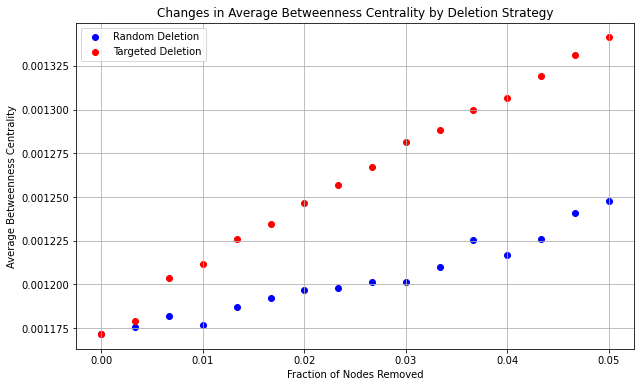

In [12]:
# Function to calculate average betweenness centrality of a network
def average_betweenness_centrality(network):
    betweenness = nx.betweenness_centrality(network)
    avg_betweenness = sum(betweenness.values()) / len(betweenness)
    return avg_betweenness

# Initialize lists to store results for plotting
fractions = np.linspace(0, 0.05, 16)  # From 0% to 7.5% in 0.5% steps
random_betweenness = []
targeted_betweenness = []

# Iterate over each fraction and perform deletions
for fraction in fractions:
    # Random node deletion
    random_network = random_node_deletion(network_nx, fraction)
    random_betweenness.append(average_betweenness_centrality(random_network))

    # Targeted node deletion
    targeted_network = targeted_node_deletion(network_nx, fraction)
    targeted_betweenness.append(average_betweenness_centrality(targeted_network))

# Plot the changes in betweenness centrality using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fractions, random_betweenness, color='blue', label='Random Deletion')
plt.scatter(fractions, targeted_betweenness, color='red', label='Targeted Deletion')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Average Betweenness Centrality')
plt.title('Changes in Average Betweenness Centrality by Deletion Strategy')
plt.legend()
plt.grid(True)
plt.show()

Random Deletion (Blue Dots): The average betweenness centrality appears to remain relatively stable or increase slightly as nodes are randomly removed. This suggests that the network has some level of resilience against random failures. Since random deletions are unlikely to consistently remove the most central nodes (which contribute most to betweenness centrality), the overall impact on the network's betweenness centrality is limited.

Targeted Deletion (Red Dots): There is a clear upward trend in average betweenness centrality as more nodes are removed in a targeted fashion. This is expected because when you remove the most connected nodes, the number of shortest paths passing through the remaining nodes tends to increase. This happens because the removal of central nodes forces the network's traffic to reroute through fewer remaining pathways, thus increasing the load (and hence the betweenness centrality) on those nodes.

From the analysis, it's evident that the network responds differently to errors and attacks:

Structural Resilience to Errors: The network's structure is not significantly perturbed by random failures, indicating a level of robustness or redundancy in connectivity that prevents any single node's failure from having a disproportionate effect.

Vulnerability to Attacks: In contrast, the network is more vulnerable to attacks that target the most connected nodes. The increase in betweenness centrality indicates that such attacks can effectively centralize the network traffic on fewer nodes, potentially creating bottlenecks that can hinder the network's functionality.

Overall, the betweenness centrality metric provides insight into the network's flow dynamics and highlights potential vulnerabilities to targeted attacks. It shows that while the network might be robust against random errors, it is more susceptible to intentional attacks that target its most connected nodes. This analysis can be crucial for designing strategies to protect the network against such vulnerabilities.

### 1.3
Repeat the above set of analyses for the network over time (e.g., for each month or quarter or year). Do you see any change in the resilience of the network over time? What patterns (if any) do you see from this temporal analysis?

In [13]:
# for each quarter 
edges_df['quarter'] = ((edges_df['year'] - 2023) * 4 + (edges_df['month']) // 3) + 1
network_quarterly={}
for quarter in edges_df['quarter'].unique():
    edges_df_quarter = edges_df[edges_df['quarter'] == quarter][['quarter','start_station_id', 'end_station_id', 'trip_count']].copy()
    edges_df_quarter[['start_station_id', 'end_station_id']] = edges_df_quarter[['start_station_id', 'end_station_id']].astype(int)

    # Sort the station IDs within each row to handle them as undirected edges
    edges_df_quarter['min_station_id'] = edges_df_quarter[['start_station_id', 'end_station_id']].min(axis=1)
    edges_df_quarter['max_station_id'] = edges_df_quarter[['start_station_id', 'end_station_id']].max(axis=1)
    # Group by the sorted station IDs and sum the trip counts
    undirectional_edges_df_quarter = edges_df_quarter.groupby(['min_station_id', 'max_station_id'])['trip_count'].sum().reset_index()

    # Remove nodes where min = max
    undirectional_edges_df_quarter = undirectional_edges_df_quarter[undirectional_edges_df_quarter.min_station_id != undirectional_edges_df_quarter.max_station_id]

    # Construct undirectional network
    min_nodes = undirectional_edges_df_quarter['min_station_id'].tolist()
    max_nodes = undirectional_edges_df_quarter['max_station_id'].tolist()
    weights = undirectional_edges_df_quarter['trip_count'].tolist()

    g = ig.Graph.TupleList(edges=zip(min_nodes, max_nodes), directed=False, edge_attrs={'weight': weights})

    network_quarterly[quarter]=g

In [14]:
no_edges=0
for quarter, g in network_quarterly.items():
    print(f"Network Nodes: {len(g.vs)}, Edges: {len(g.es)}")
    no_edges = no_edges+ len(g.es)
print(no_edges)

Network Nodes: 722, Edges: 37591
Network Nodes: 732, Edges: 56672
Network Nodes: 739, Edges: 59713
Network Nodes: 757, Edges: 57315
Network Nodes: 766, Edges: 39399
250690


In [15]:
quarterly_results = {}

for quarter, g_quarter in network_quarterly.items():
    network = nx.Graph(g_quarter.get_edgelist())
    random_avg_path_lengths = []
    random_diameters = []
    random_betweenness = []
    targeted_avg_path_lengths = []
    targeted_diameters = []
    targeted_betweenness = []
    # Iterate over each fraction and perform deletions
    for fraction in fractions:
        # Random node deletion
        random_network = random_node_deletion(network, fraction)
        if nx.is_connected(random_network):
            random_avg_path_lengths.append(nx.average_shortest_path_length(random_network))
            random_diameters.append(nx.diameter(random_network))
            random_betweenness.append(average_betweenness_centrality(random_network))
        else:
            # Handle disconnected graph
            largest_component = random_network.subgraph(max(nx.connected_components(random_network), key=len))
            random_avg_path_lengths.append(nx.average_shortest_path_length(largest_component))
            random_diameters.append(longest_shortest_path_in_largest_component(random_network))
            random_betweenness.append(average_betweenness_centrality(random_network))

        #Targeted node deletion
        targeted_network = targeted_node_deletion(network, fraction)
        if nx.is_connected(targeted_network):
            targeted_avg_path_lengths.append(nx.average_shortest_path_length(targeted_network))
            targeted_diameters.append(nx.diameter(targeted_network))
            targeted_betweenness.append(average_betweenness_centrality(targeted_network))
        else:
            # Handle disconnected graph
            targeted_avg_path_lengths.append(nx.average_shortest_path_length(largest_component))
            targeted_diameters.append(longest_shortest_path_in_largest_component(target_network))
            targeted_betweenness.append(average_betweenness_centrality(random_network))

    quarterly_results[quarter]= {'random_avg_path_lengths': random_avg_path_lengths,
        'random_diameters': random_diameters,
        'random_betweenness':random_betweenness,
        'targeted_avg_path_lengths': targeted_avg_path_lengths,
        'targeted_diameters': targeted_diameters,
        'targeted_betweenness':targeted_betweenness
    }



C:\Users\fangz\AppData\Local\Temp\ipykernel_3648\2497330095.py:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_to_remove = random.sample(network.nodes(), num_nodes_to_remove)


In [16]:
# Convert keys to strings in the quarterly_results dictionary
quarterly_results_str_keys = {str(quarter): results for quarter, results in quarterly_results.items()}

# Now you can encode quarterly_results_str_keys into JSON
import json

with open('quarterly_results.json', 'w') as f:
    json.dump(quarterly_results_str_keys, f)

In [17]:
#import matplotlib.pyplot as plt

# Define colors and markers for each quarter
#markers = ['s', 'o', '^', '*', '>']

# Create a figure and a single subplot
#fig, ax = plt.subplots(figsize=(10, 6))

#for i, (quarter, results) in enumerate(quarterly_results.items()):
#    random_avg_path_lengths = results['random_avg_path_lengths']
#    targeted_avg_path_lengths = results['targeted_avg_path_lengths']

    # Scatter plot for betweenness (random deletion)
#    ax.scatter(fractions, random_avg_path_lengths, color='red', label=f'Random Deletion_{quarter}', marker=markers[i], alpha=0.5)

    # Scatter plot for betweenness (targeted deletion)
#    ax.scatter(fractions, targeted_avg_path_lengths, color='blue', label=f'Targeted Deletion_{quarter}', marker=markers[i], alpha=0.5)

# Set labels and title
#ax.set_xlabel('Fraction of Nodes Removed')
#ax.set_ylabel('Average path length')
#plt.title('Network Resilience on Average path length to Node Deletion')

# Set legend
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

# Show grid
#ax.grid(True)

# Show plot
#plt.show()


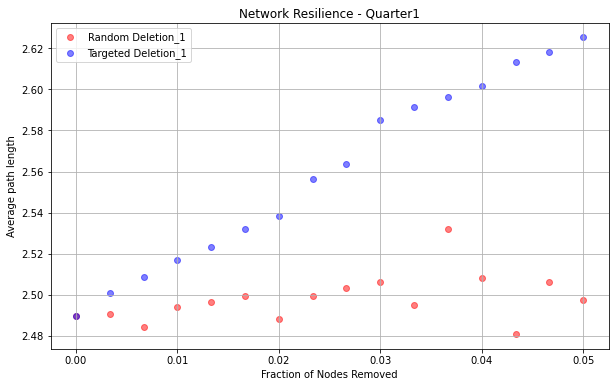

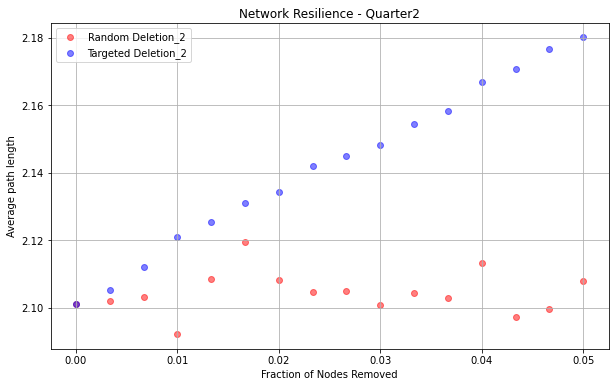

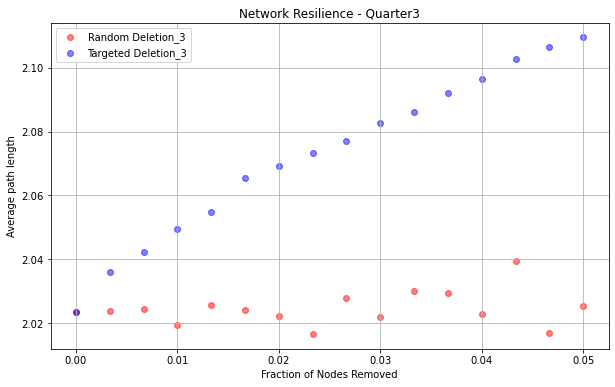

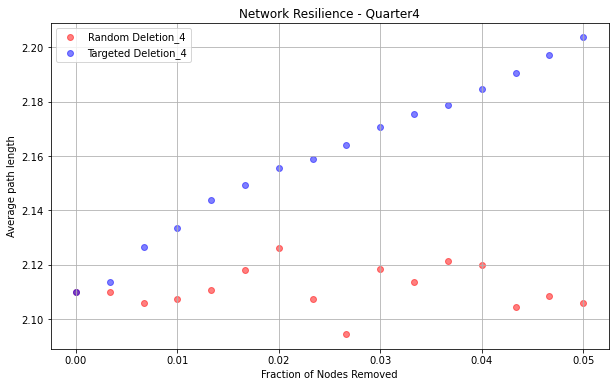

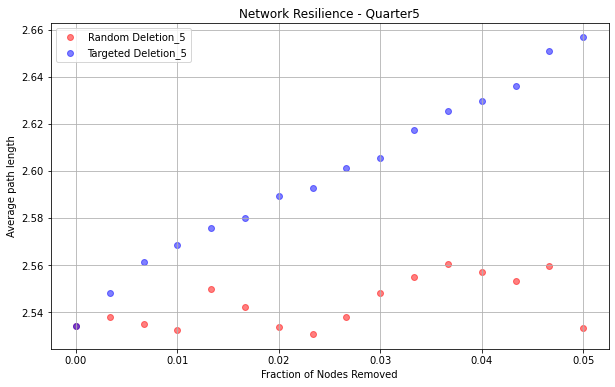

In [18]:
import matplotlib.pyplot as plt

# Iterate over quarters and create separate plots
for i, (quarter, results) in enumerate(quarterly_results.items()):
    # Create a new figure and subplot for each quarter
    fig, ax = plt.subplots(figsize=(10, 6))

    random_avg_path_lengths = results['random_avg_path_lengths']
    targeted_avg_path_lengths = results['targeted_avg_path_lengths']

    # Scatter plot for betweenness (random deletion)
    ax.scatter(fractions, random_avg_path_lengths, color='red', label=f'Random Deletion_{quarter}', marker= 'o' , alpha=0.5)

    # Scatter plot for betweenness (targeted deletion)
    ax.scatter(fractions, targeted_avg_path_lengths, color='blue', label=f'Targeted Deletion_{quarter}', marker= 'o', alpha=0.5)

    # Set labels and title
    ax.set_xlabel('Fraction of Nodes Removed')
    ax.set_ylabel('Average path length')
    ax.set_title(f'Network Resilience - Quarter{quarter}')

    # Set legend
    ax.legend(loc='upper left')

    # Show grid
    ax.grid(True)

    # Show plot
    plt.show()


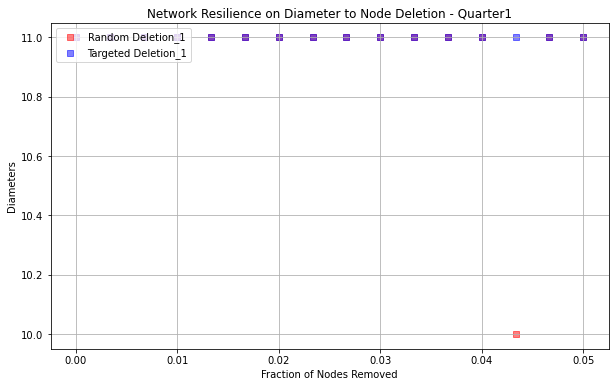

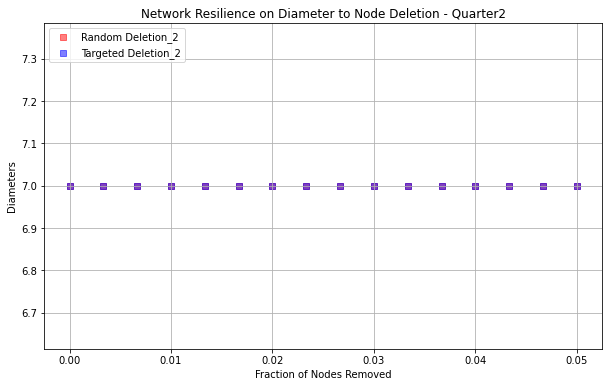

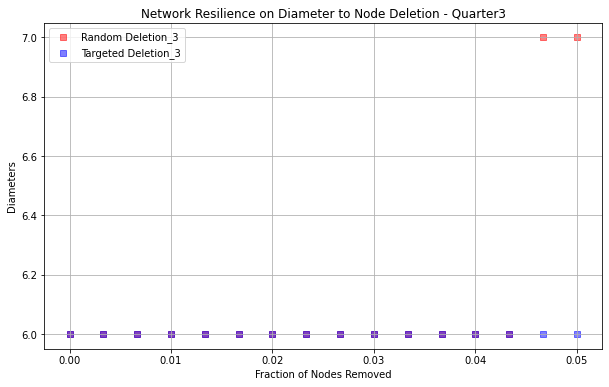

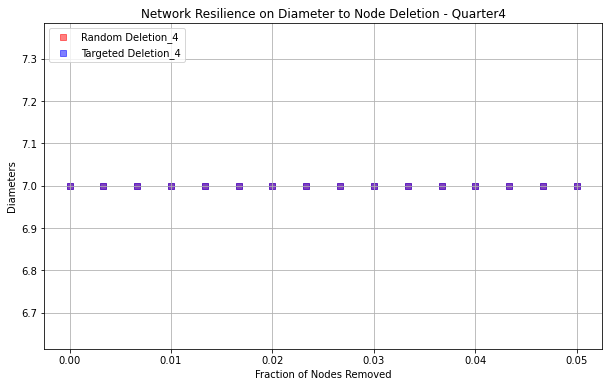

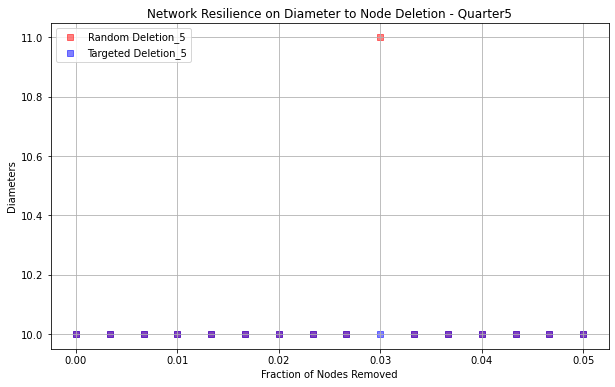

In [19]:
for i, (quarter, results) in enumerate(quarterly_results.items()):
    fig, ax = plt.subplots(figsize=(10, 6))
    random_diameters = results['random_diameters']
    targeted_diameters = results['targeted_diameters']

    # Scatter plot for betweenness (random deletion)
    ax.scatter(fractions, random_diameters, color='red', label=f'Random Deletion_{quarter}', marker= 's', alpha=0.5)

    # Scatter plot for betweenness (targeted deletion)
    ax.scatter(fractions, targeted_diameters, color='blue', label=f'Targeted Deletion_{quarter}', marker= 's', alpha=0.5)

    # Set labels and title
    ax.set_xlabel('Fraction of Nodes Removed')
    ax.set_ylabel('Diameters')
    plt.title(f'Network Resilience on Diameter to Node Deletion - Quarter{quarter}')

    # Set legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left')
    
    # Show grid
    ax.grid(True)

    # Show plot
    plt.show()


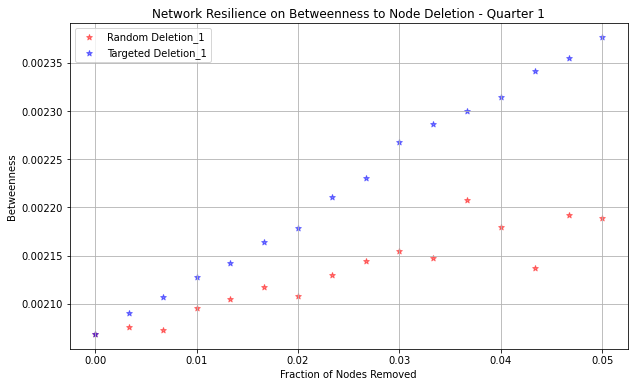

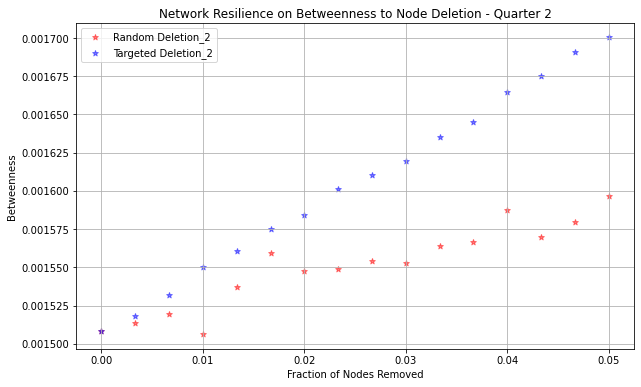

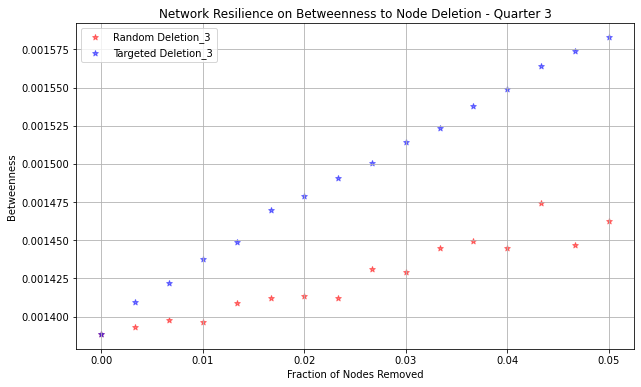

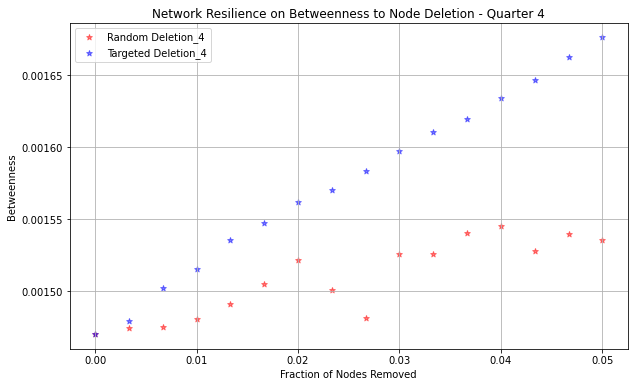

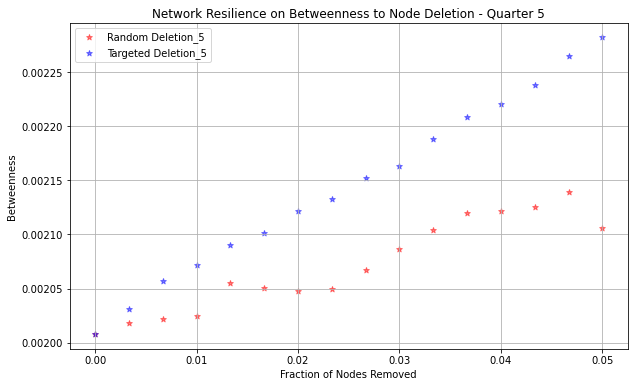

In [20]:
for i, (quarter, results) in enumerate(quarterly_results.items()):
    fig, ax = plt.subplots(figsize=(10, 6))
    random_betweenness = results['random_betweenness']
    targeted_betweenness = results['targeted_betweenness']

    # Scatter plot for betweenness (random deletion)
    ax.scatter(fractions, random_betweenness, color='red', label=f'Random Deletion_{quarter}', marker = "*", alpha=0.5)

    # Scatter plot for betweenness (targeted deletion)
    ax.scatter(fractions, targeted_betweenness, color='blue', label=f'Targeted Deletion_{quarter}', marker = "*", alpha=0.5)

    # Set labels and title
    ax.set_xlabel('Fraction of Nodes Removed')
    ax.set_ylabel('Betweenness')
    plt.title(f'Network Resilience on Betweenness to Node Deletion - Quarter {quarter}')

    # Set legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left')

    # Show grid
    ax.grid(True)

    # Show plot
    plt.show()
